import library -- import dataset -- showing label; 1 = Danger ; 0 =nonDanger -- Cleaning dataset and analysis -- EDA ( visualisasi , wordcloud) -- building model and training -- evaluation -- trying to detect

In [114]:
#Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
import re
from sklearn.utils import resample
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

In [115]:
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score

In [116]:
#Import dataset 
train = pd.read_csv('train_tweet.csv')
test = pd.read_csv('test_tweet.csv')

In [117]:
# Danger detected
train[train['label'] == 1].head()

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...


In [118]:
# NonDanger detected
train[train['label'] == 0].head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


# DATA CLEANING & ANALYSIS

In [119]:
def  cleaning_text(df, text):
    df[text] = df[text].str.lower() #membuat semua tulisan menjadi huruf kecil
    df[text] = df[text].apply(lambda elemen: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elemen))  
    #menghilangkan semua punctuation,domain dll
    return df

# diaplikasikan
training_clean = cleaning_text(train, "tweet")
testing_clean = cleaning_text(test, "tweet")


train_all = training_clean[training_clean.label==0]
train_partly = training_clean[training_clean.label==1]
sample_train = resample(train_partly, 
                        replace=True,    
                        n_samples=len(train_all),   
                        random_state=42)
train_sample = pd.concat([sample_train, train_all])
train_sample['label'].value_counts()

1    29720
0    29720
Name: label, dtype: int64

# Exploratory Data Analysis

In [120]:
#to print number of rows and columns
train.shape, test.shape 

((31962, 3), (17197, 2))

In [121]:
# Jumlah Danger = 1 , nonDanger = 0
train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [122]:
#Kolom dataset 
print('Training Set :\n',train.columns,'\n\n')
print('Testing Set','\n',test.columns)

Training Set :
 Index(['id', 'label', 'tweet'], dtype='object') 


Testing Set 
 Index(['id', 'tweet'], dtype='object')


In [123]:
#Mencari kolom dan baris yang Null
print('Menjumlahkan Nilai Null dalam test set:\n',train.isnull().sum(),'\n\n') 
print('Menjumlahkan Nilai Null dalam train set:\n',test.isnull().sum())

Menjumlahkan Nilai Null dalam test set:
 id       0
label    0
tweet    0
dtype: int64 


Menjumlahkan Nilai Null dalam train set:
 id       0
tweet    0
dtype: int64


In [124]:
# Informasi dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


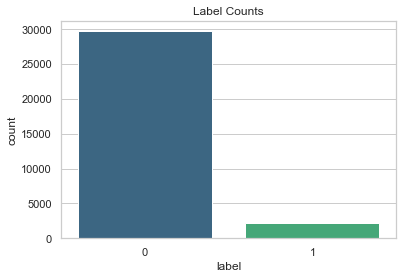

In [125]:
# Memvisualisasikan label Danger dan nonDanger
sns.set_theme(style="whitegrid")
ax1 = sns.countplot(x= 'label',
                    data = training_clean,
                    palette="viridis",
                    capsize=.1,
                   )                
plt.title('Label Counts')
plot = ax1.get_figure()

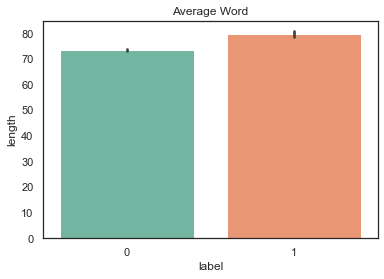

In [126]:
# Menvisualisasikan rata - rata kata 
sns.set_theme(style="white")
training_clean['length'] = training_clean['tweet'].apply(len)

ax2 = sns.barplot( x = 'label',
                   y = 'length',
                   data = training_clean,
                   palette="Set2",
                   orient = "v",
                 )
                
plt.title('Average Word')
plot = ax2.get_figure()

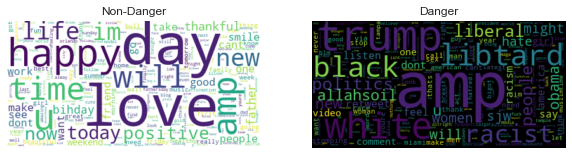

In [127]:
non_danger = " ".join(training_clean['tweet'][train.label == 0])
danger = " ".join(training_clean['tweet'][train.label == 1])

wordcloud_nondanger = WordCloud(collocations = False, 
                                background_color = 'white',
                                random_state= 42,
                                max_words=250,
                                margin=1).generate(non_danger)

wordcloud_danger = WordCloud(collocations = False, 
                             background_color = 'black',
                             random_state=42,
                             max_words=250,
                             margin=1).generate(danger)

fig, axs = plt.subplots(1,2 , figsize=(10,5)) #posisi kanan kiri 1-2 , ukuran 10,5

# Visualisasi untuk nondanger 
axs[0].imshow(wordcloud_nondanger, interpolation='bilinear')
axs[0].axis('off') #ngilangin garis pinggir dan angka skala
axs[0].set_title('Non-Danger')

#visualisasi untuk danger
axs[1].imshow(wordcloud_danger, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Danger')

plt.show()

In [128]:
# Menghitung distribusi dari kata
import cufflinks as cf

cf.go_offline()
cf.set_config_file(offline=False ,
                   world_readable=True)

training_clean['length'].iplot(
    kind='hist',
    bins=50,
    xTitle='word count',
    orientation='h',
    yTitle='count',
    colors="Navy",
    linecolor='Yellow',
    title='Distribusi Jumlah Kata Teks')

# Build Model and Training Model

In [129]:
xgb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf',  TfidfTransformer()),
    ('nb', xgb.XGBClassifier(use_label =False)),])

# split data
x_train, x_test, y_train, y_test = train_test_split(train_sample['tweet'],
                                                    train_sample['label'])

In [130]:
#build model
model = xgb.fit(x_train, y_train)
y_predict = model.predict(x_test)

[14:44:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "use_label" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [131]:
print('F1_Score: ',f1_score(y_test, y_predict))
print('Accuracy_Score: ', accuracy_score(y_test, y_predict))

F1_Score:  0.9127883717829043
Accuracy_Score:  0.911978465679677


In [139]:
def predict(input):
    input = pd.Series(input)
    y_predict = ((np.ravel(model.predict(input)).tolist()))
    if y_predict[-1] == 1:
        print('Result : DANGEROUS DETECTED')
    if y_predict[-1] == 0:
        print('Result: NON DANGEROUS DETECTED')
    

input = [' I hate humans !! they suck', 'I like playing ','you fucked','black people always sad']
for i in input:
    print('Your Sentences -> ', i)
    predict(i)
    print('xx'*30,'\n')

Your Sentences ->   I hate humans !! they suck
Result : DANGEROUS DETECTED
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Your Sentences ->  I like playing 
Result: NON DANGEROUS DETECTED
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Your Sentences ->  you fucked
Result : DANGEROUS DETECTED
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

Your Sentences ->  black people always sad
Result : DANGEROUS DETECTED
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx 

